In [1]:
import os
import tempfile
from zipfile import ZipFile

import gdown
import matplotlib.pyplot as plt

from data_load_utils import train_test_val_img_dataset
import keras

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
TEST_SIZE = 0.2
VAL_SIZE = 0.2

## Carga dos dados

Os dados usados para a construção do modelo são do conjunto [MC Answer Boxes Dataset](https://sites.google.com/view/mcq-dataset), que contém diversos testes de múltipla escolha respondidos. Neste conjunto de dados, já temos as caixas de resposta de cada teste extraída e com a marcação entre "confirmada", "vazia" ou "cancelada".

Os dados estão disponíveis publicamente no Google Drive, e é possível fazer o download automático usando o pacote `gdown`.

Um diretório temporário é criado, os arquivos são baixados do Google Drive para este diretório e então são descompactados criando a pasta data.

Dentro da pasta data, são criados diretórios para cada classe ("confirmed", "empty" e "crossedout").

In [2]:
if not os.path.exists("data"):
    ids = {
        "empty": "1NH3MTPqwPk25Zz127D6SP45dNnFkQB5e&confirm=t",
        "crossedout": "19_8vPdpYqO1WrM5gbchrRNDEXxjiIKLC&confirm=t",
        "confirmed": "1iQ8x12DvT7s15IUDegI87aJtcUMECXqU&confirm=t",
    }

    with tempfile.TemporaryDirectory() as tmpdirname:
        print("created temporary directory", tmpdirname)
        for name, id in ids.items():
            gdown.download(id=id, output=os.path.join(tmpdirname, f"{name}.zip"))

        for file in os.listdir(tmpdirname):
            with ZipFile(os.path.join(tmpdirname, file), "r") as zip:
                zip.extractall(path="data")

created temporary directory C:\Users\vgcap\AppData\Local\Temp\tmpg0z32k9m


Downloading...
From: https://drive.google.com/uc?id=1NH3MTPqwPk25Zz127D6SP45dNnFkQB5e&confirm=t
To: C:\Users\vgcap\AppData\Local\Temp\tmpg0z32k9m\empty.zip
100%|██████████| 68.6M/68.6M [00:06<00:00, 10.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=19_8vPdpYqO1WrM5gbchrRNDEXxjiIKLC&confirm=t
To: C:\Users\vgcap\AppData\Local\Temp\tmpg0z32k9m\crossedout.zip
100%|██████████| 2.34M/2.34M [00:00<00:00, 6.03MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iQ8x12DvT7s15IUDegI87aJtcUMECXqU&confirm=t
To: C:\Users\vgcap\AppData\Local\Temp\tmpg0z32k9m\confirmed.zip
100%|██████████| 144M/144M [00:06<00:00, 23.8MB/s] 


## Leitura do dataset

As funções de leitura auxliares do Keras permitem apenas a separação dos dados em treino e validação.

Eu acredito que seja interessante ter um conjunto extra, de teste, com dados que não foram usados de nenhuma forma no treinamento do modelo.

Para isso, utilizei algumas funções auxiliares para criar o conjunto de dados.

In [3]:
train_ds, test_ds, val_ds, class_names = train_test_val_img_dataset(
    "data", test_size=TEST_SIZE, val_size=VAL_SIZE, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE
)

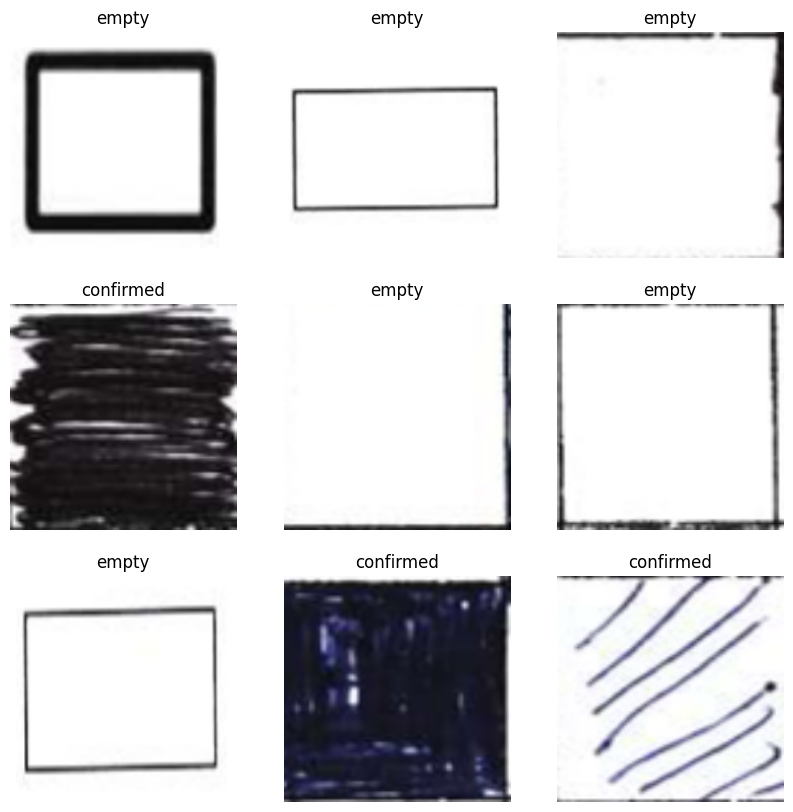

In [4]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

## Definição do modelo

O modelo utilizado é um modelo treinado usando trasnfer learning com o modelo Xception.

Foi incluído um passo de preprocessamento para ajustar o tamanho das imagens para o tamanho desejado pelo modelo.
Por mais que os conjuntos de dados usados no treino e no teste já estejam com o tamanho correto, no momento da previsão podem ser passadas imagens de qualquer tamanho que serão ajustadas para o tamanho correto.

Além disso, foi incluído um passo de normalização, que ajusta os valores para o intervalo [-1, 1].

In [5]:
def make_model(input_shape, num_classes):
    base_model = keras.applications.Xception(
        weights="imagenet",
        input_shape=input_shape + (3,),
        include_top=False,
    )
    base_model.trainable = False

    inputs = keras.Input(shape=[None, None, 3])
    # Step de pré-processamento para ajudar na previsão - isso me permite 
    # usar imagens de qualquer tamanho na hora de realizar a previsão.
    naive_resize = keras.layers.Resizing(*input_shape)(inputs)

    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(naive_resize)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=IMAGE_SIZE, num_classes=3)
model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, None, None, 3) │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resizing (Resizing)         │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 7, 7, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Ajuste do modelo

In [6]:
if not os.path.exists("models"):
    os.makedirs("models")

callbacks = [
    keras.callbacks.ModelCheckpoint("models/checkpoint/save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=5,
    callbacks=callbacks,
    validation_data=val_ds,
)

model.save("models/omr_model.keras")

Epoch 1/5
 18/630 ━━━━━━━━━━━━━━━━━━━━ 14:20 1s/step - acc: 0.6166 - loss: 0.9492